In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import huggingface_hub as hf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
from transformers import AutoTokenizer, AutoModel

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 256)

plt.style.use('seaborn-v0_8')
load_dotenv()
hf.login(os.environ["HF_TOKEN"])
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/mohsenfayyaz/.cache/huggingface/token
Login successful
CUDA_VISIBLE_DEVICES: 6 HF_HOME: /local1/mohsenfayyaz/.hfcache/


In [2]:
# DATASET = "re-docred_facebook--contriever-msmarco_7170.pkl"
DATASET = "re-docred_facebook--dragon-plus-query-encoder_7170.pkl"
# DATASET = "re-docred_OpenMatch--cocodr-base-msmarco_7170.pkl.gz"

hf.hf_hub_download(repo_id="Retriever-Contextualization/datasets", filename=f"results/{DATASET}", repo_type="dataset", local_dir="hf/")

'hf/results/re-docred_facebook--dragon-plus-query-encoder_7170.pkl'

In [7]:
df_raw = pd.read_pickle(f"./hf/results/{DATASET}")
print(df_raw.attrs)
df_raw.head(1)

{'model': 'facebook/dragon-plus-query-encoder', 'query_model': 'facebook/dragon-plus-query-encoder', 'context_model': 'facebook/dragon-plus-context-encoder', 'pooling': 'cls', 'dataset': 're-docred', 'corpus_size': 105925, 'eval': {'ndcg': {'NDCG@1': 0.47685, 'NDCG@3': 0.52523, 'NDCG@5': 0.53646, 'NDCG@10': 0.54955, 'NDCG@100': 0.58002, 'NDCG@1000': 0.59556}, 'map': {'MAP@1': 0.47685, 'MAP@3': 0.51341, 'MAP@5': 0.51959, 'MAP@10': 0.52496, 'MAP@100': 0.53058, 'MAP@1000': 0.53109}, 'recall': {'Recall@1': 0.47685, 'Recall@3': 0.55941, 'Recall@5': 0.58689, 'Recall@10': 0.62748, 'Recall@100': 0.77741, 'Recall@1000': 0.90349}, 'precision': {'P@1': 0.47685, 'P@3': 0.18647, 'P@5': 0.11738, 'P@10': 0.06275, 'P@100': 0.00777, 'P@1000': 0.0009}}}


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
0,test0,When was Loud Tour published?,[Loud Tour],"{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...","{'len': 1000, 'max': 390.3378601074219, 'min': 377.525390625, 'std': 1.243663421340353, 'mean': 378.77503692626954, 'median': 378.4281463623047}",{'Loud Tour': 390.3378601074219},"{'Loud Tour': 390.3378601074219, 'Loud'n'proud': 385.71905517578125, 'Poetry Bus Tour': 385.4292907714844, 'Live &amp; Loud': 384.18218994140625, 'The Loudest Engine': 384.0265808105469, 'Young Wild Things Tour': 383.8572998046875, 'Guitar Rock Tour': ...","{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...",test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3]...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}, {'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}, {'r': 'P17', 'h': 8, 't': 7, 'evidence': [3, 4]}, {'r': 'P17', 'h': 10, 't': 7, 'evidence': [3, 4]}, {'...","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3],...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]","{Loud, Loud Tour}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihanna, 's, fifth, studio, album, Loud, (, 2010, ), .]]","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}]","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]",P577,publication date,When was Loud Tour published?,0,{},1.0,"Loud Tour The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the A

In [8]:
class YourCustomDEModel:
    def __init__(self, q_model, doc_model, pooling, sep: str = " ", **kwargs):
        self.tokenizer = AutoTokenizer.from_pretrained(q_model)
        self.query_encoder = AutoModel.from_pretrained(q_model)
        self.context_encoder = AutoModel.from_pretrained(doc_model)
        self.pooling = pooling
        self.sep = sep
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Write your own encoding query function (Returns: Query embeddings as numpy array)
    def encode_queries(self, queries: List[str], batch_size=32, **kwargs) -> np.ndarray:
        print("Q")
        print(len(queries))
        return self.encode_in_batch(self.query_encoder, queries, batch_size)
    
    # Write your own encoding corpus function (Returns: Document embeddings as numpy array)  
    def encode_corpus(self, corpus: List[Dict[str, str]], batch_size=32, **kwargs) -> np.ndarray:
        if type(corpus) is dict:
            sentences = [(corpus["title"][i] + self.sep + corpus["text"][i]).strip() if "title" in corpus else corpus["text"][i].strip() for i in range(len(corpus['text']))]
        else:
            sentences = [(doc["title"] + self.sep + doc["text"]).strip() if "title" in doc else doc["text"].strip() for doc in corpus]
        return self.encode_in_batch(self.context_encoder, sentences, batch_size)

    def encode_in_batch(self, model, sentences: List[str], batch_size=32, **kwargs) -> np.ndarray:
        model.to(self.device)
        all_embeddings = []
        for batch in tqdm(torch.utils.data.DataLoader(sentences, batch_size=batch_size, shuffle=False)):
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            outputs = model(**inputs)
            ### POOLING
            if self.pooling == "avg":
                embeddings = self.mean_pooling(outputs[0], inputs['attention_mask'])
            elif self.pooling == "cls":
                embeddings = outputs.last_hidden_state[:, 0, :]  # [128, 768] = [batch, emb_dim]
            else:
                raise ValueError("Pooling method not supported")
            all_embeddings.extend(embeddings.detach().cpu().numpy())
        all_embeddings = np.array(all_embeddings)
        print(all_embeddings.shape)
        return all_embeddings

    def mean_pooling(self, token_embeddings, mask):
        token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
        sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
        return sentence_embeddings

In [13]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
]

df = df_raw.copy()
def flatten(xss):
    return [x for xs in xss for x in xs]
df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))

plot_col_dots = []
for query_model, context_model, POOLING in cfgs:
    dpr = YourCustomDEModel(query_model, context_model, POOLING)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    
    embds = dpr.encode_corpus(to_doc_format(df['sents_complete'].to_list()))
    query_embds = dpr.encode_queries(df['query'].to_list())
    embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
    new_col = f"{query_model}_dot"
    print(new_col)
    df[new_col] = embds_dot
    plot_col_dots.append(new_col)

  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)
Q
7170


  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)
facebook/dragon-plus-query-encoder_dot


/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)
Q
7170


  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)
facebook/contriever-msmarco_dot


  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)
Q
7170


  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)
OpenMatch/cocodr-base-msmarco_dot


/tmp/ipykernel_2987126/2015113589.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dfp = df.pivot_table(index="gold_doc_len_digitized", columns="head_count_digitized", values=col, aggfunc="mean")


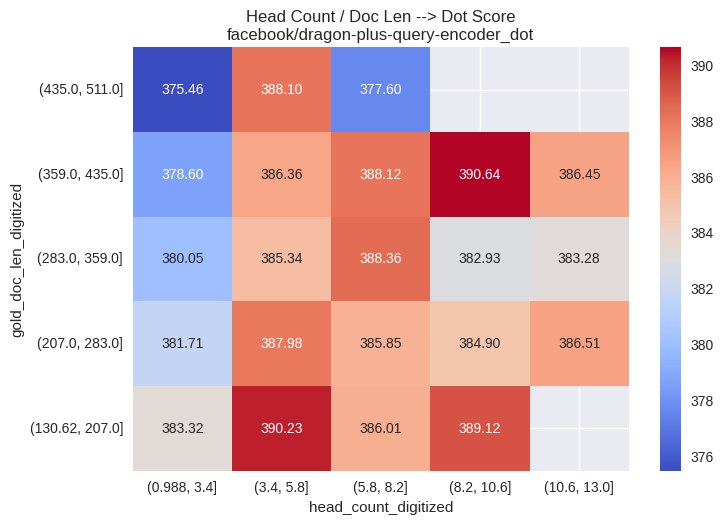

/tmp/ipykernel_2987126/2015113589.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dfp = df.pivot_table(index="gold_doc_len_digitized", columns="head_count_digitized", values=col, aggfunc="mean")


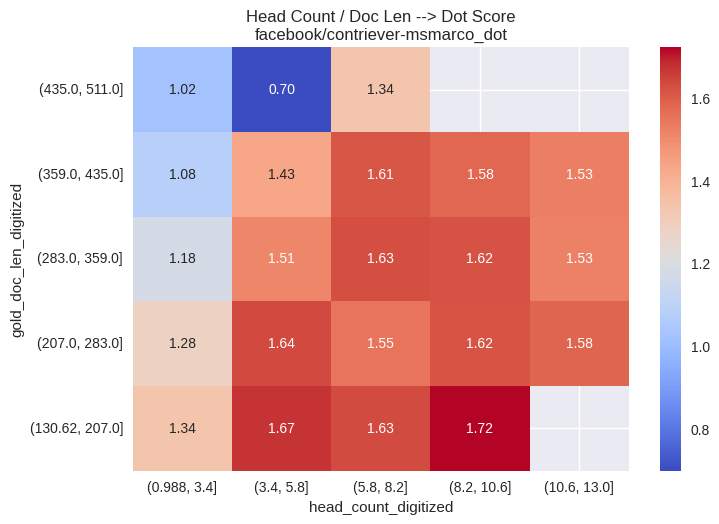

/tmp/ipykernel_2987126/2015113589.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dfp = df.pivot_table(index="gold_doc_len_digitized", columns="head_count_digitized", values=col, aggfunc="mean")


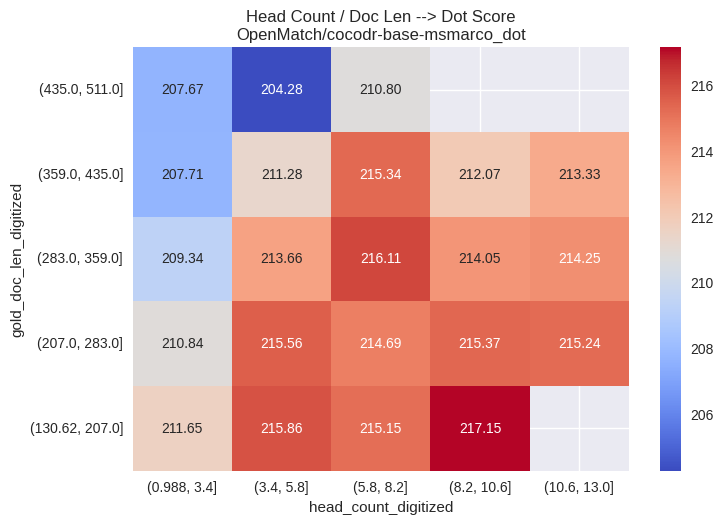

In [24]:
df["head_count"] = df["head_entity"].str.len()
bins = 5
df["head_count_digitized"] = digitize_col(df["head_count"], bins=bins)
df["gold_doc_len_digitized"] = digitize_col(df["gold_doc_len"], bins=bins)

# df = df[["head_entity", "head_count", "gold_doc_len", "head_count_digitized", "gold_doc_len_digitized"]]
for col in plot_col_dots:
    dfp = df.pivot_table(index="gold_doc_len_digitized", columns="head_count_digitized", values=col, aggfunc="mean")
    dfp = dfp.reindex(index=dfp.index[::-1])
    sns.heatmap(dfp, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"Head Count / Doc Len --> Dot Score\n{col}")
    plt.show()


In [6]:
import numpy as np

# Example list
data = [0.2, 6.4, 3.0, 1.6, 2.5, 4.0, 10.0]

# Number of bins
n_bins = 4

# Create bins of equal space
hist, bin_edges = np.histogram(data, bins=n_bins)
inds = np.digitize(data, bin_edges)

print("Histogram:", hist)
print("Bin edges:", bin_edges)
print(inds)

Histogram: [3 2 1 1]
Bin edges: [ 0.2   2.65  5.1   7.55 10.  ]
[1 3 2 1 1 2 5]


In [ ]:
x = np.array([0.2, 6.4, 3.0, 1.6])
bins = np.array([0.0, 1.0, 2.5, 4.0, 10.0])
inds = np.digitize(x, bins)

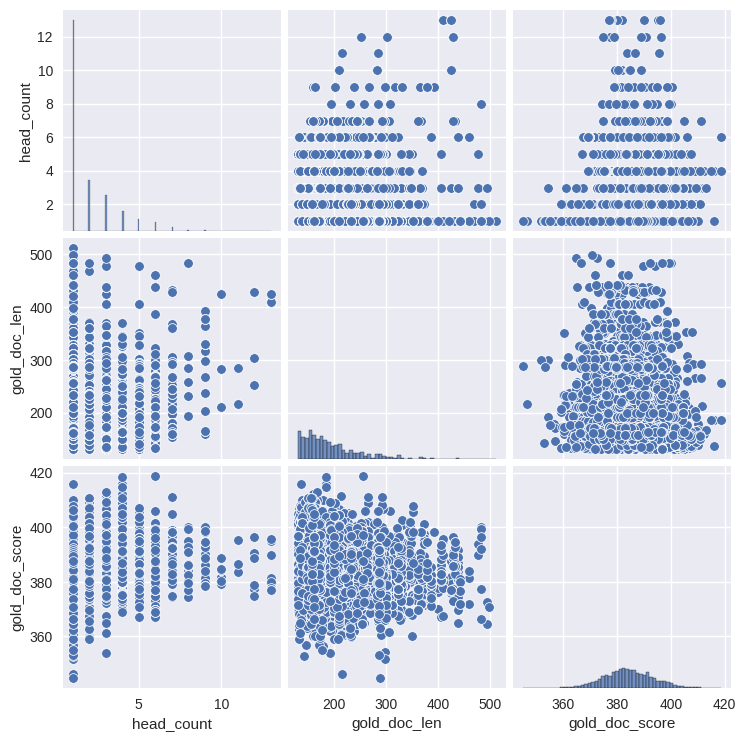

In [67]:
# sns.heatmap(df[["head_count", "gold_doc_len", "gold_doc_score"]].pivot(index="head_count", columns="gold_doc_len", values="gold_doc_score"), annot=True, cmap="coolwarm", fmt=".2f")
# sns.histplot(df, x="head_count", y="gold_doc_len")
# plt.ylim(120, 250)
sns.pairplot(df[["head_count", "gold_doc_len", "gold_doc_score"]])
# sns.violinplot(data=df, x="head_count", y="gold_doc_score", inner_kws=dict(box_width=7, whis_width=2, color=".8"))
# sns.violinplot(data=df, x="gold_doc_len", y="gold_doc_score", inner_kws=dict(box_width=7, whis_width=2, color=".8"))

<Axes: xlabel='gold_doc_len', ylabel='Count'>

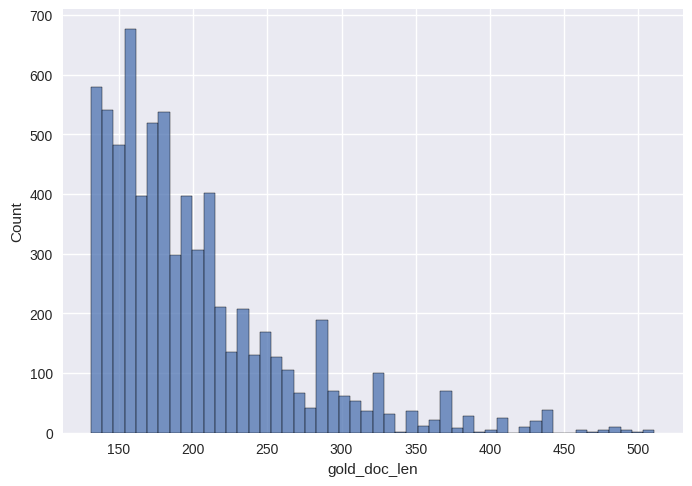

In [22]:
sns.histplot(df["gold_doc_len"], bins=50)

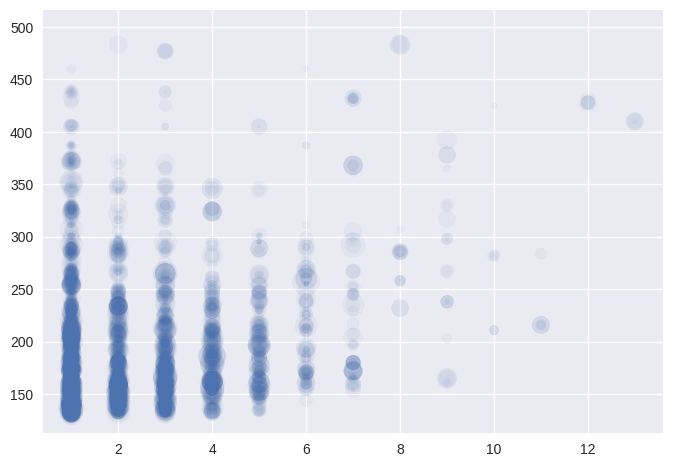

In [66]:
df2 = df.copy().dropna()

plt.scatter(df2["head_count"], df2["gold_doc_len"], s=10 * np.maximum(0, df2["gold_doc_score"] - 380), alpha=0.05)

<Axes: xlabel='gold_doc_len', ylabel='gold_doc_score'>

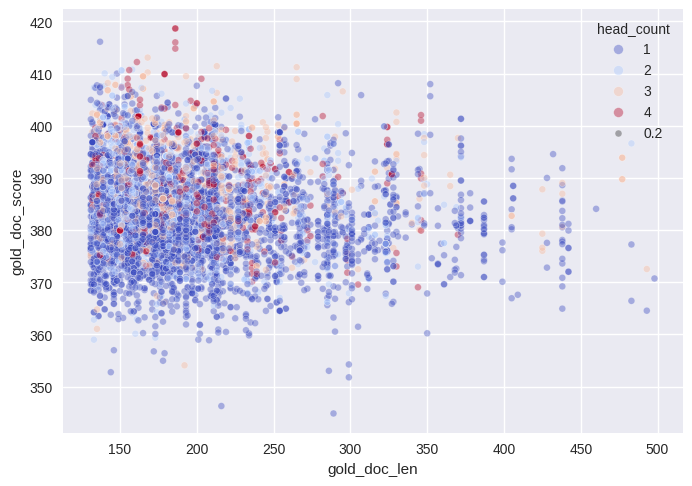

In [73]:
df2 = df.copy().dropna()
df2 = df2[df2["head_count"] < 5]
sns.scatterplot(data=df2, x="gold_doc_len", y="gold_doc_score", hue="head_count", palette="coolwarm", alpha=0.4, size=0.2)

In [44]:
np.maximum(0, df2["gold_doc_score"]) / np.median(df2["gold_doc_score"])

0       1.016338
1       1.037336
3       0.982230
5       1.002493
6       0.986448
          ...   
7165    0.965637
7166    1.020107
7167    1.012324
7168    0.940143
7169    0.949871
Name: gold_doc_score, Length: 6478, dtype: float64

<Axes: >

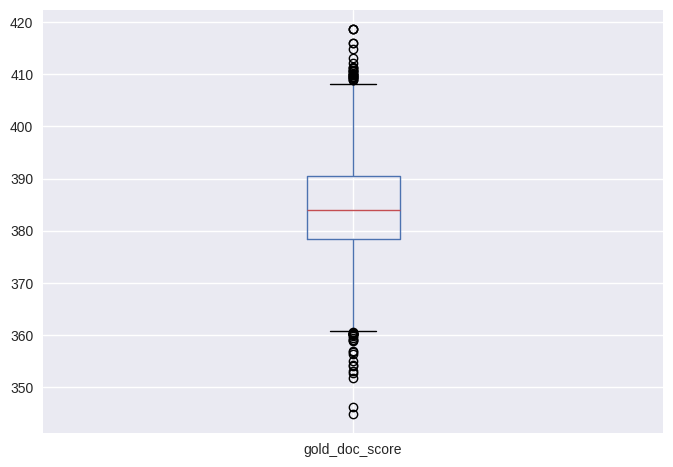

In [47]:
df2[["gold_doc_score"]].boxplot()